In [2]:
!pip install ortools

Route for Vehicle 0:
 0 (Load: 0, Time: 0) ->  3 (Load: 2, Time: 90) ->  2 (Load: 3, Time: 107) -> 0 (Time: 191)
Distance: 18659m

Route for Vehicle 1:
 0 (Load: 0, Time: 1) ->  4 (Load: 1, Time: 50) ->  1 (Load: 2, Time: 101) ->  6 (Load: 3, Time: 169) -> 0 (Time: 262)
Distance: 23410m

Route for Vehicle 2:
 0 (Load: 0, Time: 0) ->  5 (Load: 2, Time: 22) -> 0 (Time: 44)
Distance: 4500m



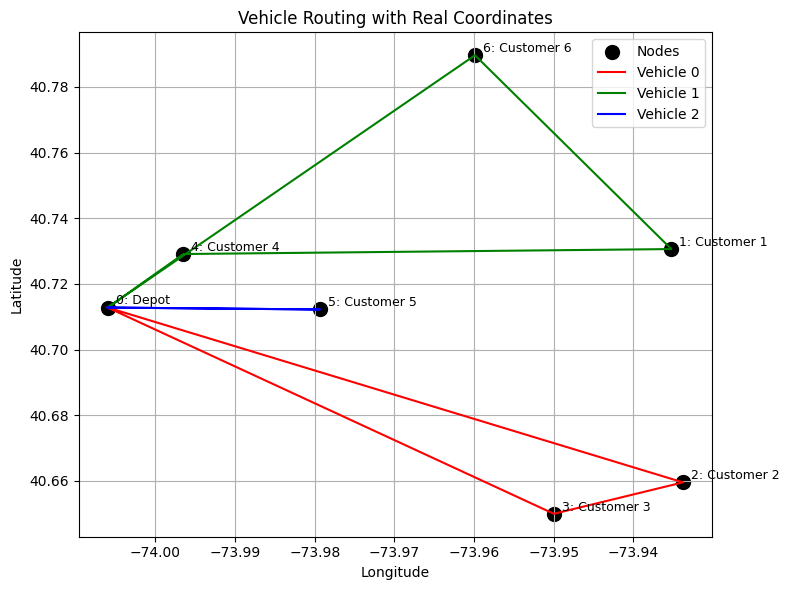

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from geopy.distance import geodesic

# Define real coordinates for depot and customers (latitude, longitude)
locations = {
    "Depot": (40.7128, -74.0060),   # New York
    "Customer 1": (40.730610, -73.935242),  # Queens
    "Customer 2": (40.659569, -73.933783),  # Brooklyn
    "Customer 3": (40.650002, -73.949997),  # Brooklyn
    "Customer 4": (40.7291, -73.9965),      # Manhattan
    "Customer 5": (40.712217, -73.979378),  # Lower East Side
    "Customer 6": (40.7896239, -73.9598939) # Upper East Side
}

# Demands and time windows (minutes since depot start time = 0)
demands = [0, 1, 1, 2, 1, 2, 1]
time_windows = [(0, 300), (30, 120), (60, 180), (90, 240), (50, 200), (0, 150), (20, 170)]
vehicle_capacities = [3, 3, 3]
num_vehicles = 3
depot_index = 0

# Compute distance matrix using Haversine
coords = list(locations.values())
n = len(coords)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            distance_matrix[i][j] = int(geodesic(coords[i], coords[j]).meters)

# Compute time matrix assuming 1 meter = 0.01 minute
time_matrix = (distance_matrix * 0.01).astype(int)

def create_data_model():
    return {
        'distance_matrix': distance_matrix.tolist(),
        'time_matrix': time_matrix.tolist(),
        'demands': demands,
        'time_windows': time_windows,
        'vehicle_capacities': vehicle_capacities,
        'num_vehicles': num_vehicles,
        'depot': depot_index
    }

def print_solution(data, manager, routing, solution, time_dimension):
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for Vehicle {vehicle_id}:\n'
        route_distance, route_load = 0, 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            time_var = solution.Value(time_dimension.CumulVar(index))
            plan_output += f' {node_index} (Load: {route_load}, Time: {time_var}) -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        time_var = solution.Value(time_dimension.CumulVar(index))
        plan_output += f'{manager.IndexToNode(index)} (Time: {time_var})\nDistance: {route_distance}m\n'
        print(plan_output)

def main():
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return int(data['distance_matrix'][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        return data['demands'][manager.IndexToNode(from_index)]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index, 0, data['vehicle_capacities'], True, 'Capacity')

    def time_callback(from_index, to_index):
        return data['time_matrix'][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_callback_index,
        30,  # allow waiting time
        300,  # vehicle maximum travel time
        False,
        'Time'
    )
    time_dimension = routing.GetDimensionOrDie('Time')

    for location_idx, time_window in enumerate(data['time_windows']):
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    solution = routing.SolveWithParameters(search_params)

    if solution:
        print_solution(data, manager, routing, solution, time_dimension)

        # Plotting routes
        plt.figure(figsize=(8, 6))
        colors = ['red', 'green', 'blue', 'purple']
        loc_array = np.array(coords)
        plt.scatter(loc_array[:,1], loc_array[:,0], c='black', s=100, label='Nodes')
        for i, name in enumerate(locations.keys()):
            plt.text(loc_array[i][1]+0.001, loc_array[i][0]+0.001, f"{i}: {name}", fontsize=9)

        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))

            route_coords = [coords[i] for i in route]
            lats, lons = zip(*route_coords)
            plt.plot(lons, lats, color=colors[vehicle_id % len(colors)], label=f"Vehicle {vehicle_id}")

        plt.title("Vehicle Routing with Real Coordinates")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        print("No solution found!")

main()
